In [1]:
import numpy as np
import scipy.fftpack as fp
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.restoration import wiener, unsupervised_wiener
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

In [4]:
def pseudo_inverse_filter(y, h, epsilon):
  Hf = fp.fft2(fp.ifftshift(h))
  M, N = Hf.shape
  Hf[(np.abs(Hf) < epsilon)] = 0
  indices = np.where((np.abs(Hf) >= epsilon))
  Hf[indices] = np.ones((M, N))[indices] / Hf[indices]
  Yf = fp.fft2(y)
  I = Yf * Hf
  im = np.abs(fp.ifft2(I))
  return (im, Hf)

In [5]:
def cls_filter(y, h, c, lambd):
  Hf = fp.ftt2(fp.ifftshift(h))
  Cf = fp.fft2(fp.ifftshift(c))
  Hf = np.conj(Hf) / (Hf* np.confj(Hf) + lambd*Cf*np.conj(Cf))
  Yf = fp.fft2(y)
  I = Yf * Hf
  im = np.abs(fp.ifft2(I))
  return (im, Hf)

(720, 540)
1.0


Text(0.5, 1.0, 'Degraded (PSNR: 21.794)')

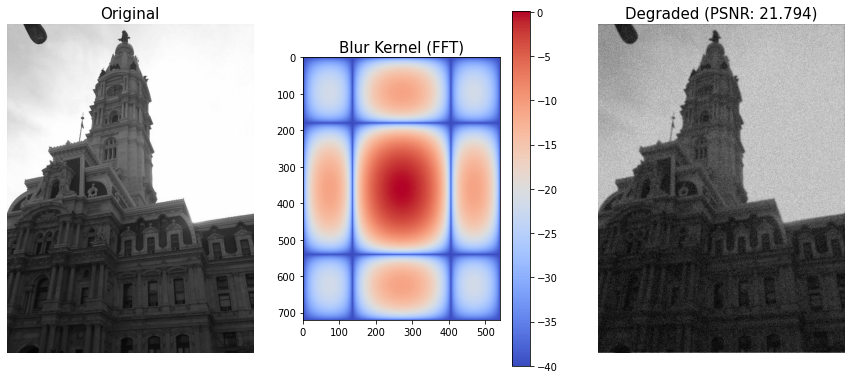

In [8]:
x = rgb2gray(imread('imagenes/building.png'))
print(x.shape)
M, N = x.shape
print(np.max(x))

plt.figure(figsize=(15, 30))

plt.subplot(431), plt.imshow(x, cmap='gray'), plt.axis('off'), plt.title('Original', size=15)

h = np.ones((4, 4)) / 16
h = np.pad(h, [(M//2 - 2, M//2 - 2), (N//2 - 2, N//2 - 2)], 'constant')
sigma = 0.075
Xf = fp.fft2(x)
Hf = fp.fft2(fp.ifftshift(h))

plt.subplot(432), plt.imshow(20*np.log10(0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'),
plt.title('Blur Kernel (FFT)', size=15), plt.colorbar()

Y = Hf * Xf
y = fp.ifft2(Y).real + sigma * np.random.randn(M, N)

plt.subplot(433), plt.imshow(np.abs(y), cmap='gray'), plt.axis('off'),
plt.title(f'Degraded (PSNR: {np.round(psnr(x, y), 3)})', size=15)

## Primer intento

epsilon = 0.25
pix, F_pseudo = pseudo_inverse_filter(y, h, epsilon)

plt.subplot(434), plt.imshow(pix, cmap='gray'), plt.axis('off'),
plt.title(f'Restored Pseudo-inverse (PSNR: {np.round(psnr(x, pix), 3)})', size=15)


plt.subplot(435), plot_freq_filter(F_pseudo, 'Pseudo-inverse Filter (FFT)', size=15)

